In [19]:
import numpy as np 
import pandas as pd
import re
#import gc
#import os
#print(os.listdir("../input"))
#import fileinput
#import string
import tensorflow as tf
#import zipfile
#import datetime
#import sys
#from tqdm  import tqdm
#tqdm.pandas()
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

pd.set_option('display.max_colwidth', None)


In [2]:
dataset = pd.read_csv('root2aidata.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22704 entries, 0 to 22703
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    22701 non-null  object
 1   Target  22704 non-null  object
dtypes: object(2)
memory usage: 354.9+ KB


In [4]:
dataset['Target'].unique()

array(['Blockchain', 'Bigdata', 'credit reporting', 'Cyber Security',
       'FinTech', 'Microservices', 'Neobanks', 'Robo Advising',
       'Stock Trading', 'Data Security', 'Reg Tech'], dtype=object)

In [5]:
dataset.loc[dataset['Text'].isnull()]

,Text,Target
16661,NaN,Microservices
16940,NaN,Microservices
17073,NaN,Microservices


In [6]:
dataset['Target'].value_counts()

FinTech             8551
Cyber Security      2640
Bigdata             2267
Reg Tech            2206
credit reporting    1748
Blockchain          1375
Neobanks            1069
Microservices        977
Stock Trading        787
Robo Advising        737
Data Security        347
Name: Target, dtype: int64

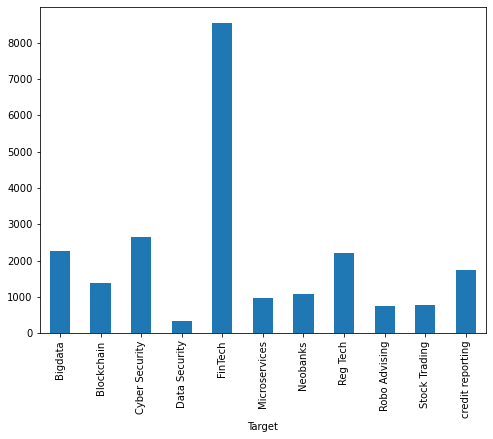

In [7]:
#observing the distribution texts with respect to the target variable 
fig = plt.figure(figsize=(8,6))
dataset.groupby('Target').Text.count().plot.bar(ylim=0)
plt.show()

In [8]:
df = dataset.copy()

In [9]:
dataset.loc[dataset['Text'].isnull()]
df = df[pd.notnull(df['Text'])]


In [10]:
one_hot = pd.get_dummies(df["Target"])
df.drop(['Target'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,Text,Bigdata,Blockchain,Cyber Security,Data Security,FinTech,Microservices,Neobanks,Reg Tech,Robo Advising,Stock Trading,credit reporting
0,reserve bank forming expert committee based institute development research banking technology study approach distributed ledger technology help support shift,0,1,0,0,0,0,0,0,0,0,0
1,director could play role financial system,0,1,0,0,0,0,0,0,0,0,0
2,preliminary discuss secure transaction study research payment,0,1,0,0,0,0,0,0,0,0,0
3,security indeed prove essential transforming financial system part effort move away heavy reliance cash based,0,1,0,0,0,0,0,0,0,0,0
4,bank settlement normally take three days based payment verification technology take less tier security,0,1,0,0,0,0,0,0,0,0,0


# splitting into training and test sets

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Text'].values, df.drop(['Text'],axis=1).values, test_size=0.2, random_state=42)

# Tokenizing texts for embedding matrix

In [12]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=50)

In [37]:
X_train[:30, :]

array([[   0,    0,    0, ...,   37,  128,  111],
       [   0,    0,    0, ..., 1719,  663,  414],
       [   0,    0,    0, ..., 2068, 1720,  379],
       ...,
       [   0,    0,    0, ...,   19,  968,  271],
       [   0,    0,    0, ..., 5081,  805,  615],
       [   0,    0,    0, ..., 1971,  476, 1468]])

In [14]:
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=50)

# Creating a LSTM model

In [22]:
epochs = 10
emb_dim = 128
batch_size = 256

In [24]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=50))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1111      
Total params: 2,099,175
Trainable params: 2,099,175
Non-trainable params: 0
____________________________________________

In [26]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Epoch 1/10
57/57 [==============================] - 6s 104ms/step - loss: 2.0408 - accuracy: 0.3722 - val_loss: 1.9509 - val_accuracy: 0.3720
Epoch 2/10
57/57 [==============================] - 6s 100ms/step - loss: 1.7320 - accuracy: 0.4586 - val_loss: 1.5522 - val_accuracy: 0.5303
Epoch 3/10
57/57 [==============================] - 6s 99ms/step - loss: 1.2829 - accuracy: 0.6070 - val_loss: 1.3231 - val_accuracy: 0.5997
Epoch 4/10
57/57 [==============================] - 5s 95ms/step - loss: 0.9525 - accuracy: 0.7071 - val_loss: 1.2131 - val_accuracy: 0.6390
Epoch 5/10
57/57 [==============================] - 5s 96ms/step - loss: 0.7326 - accuracy: 0.7752 - val_loss: 1.2188 - val_accuracy: 0.6415
Epoch 6/10
57/57 [==============================] - 6s 97ms/step - loss: 0.5801 - accuracy: 0.8214 - val_loss: 1.2571 - val_accuracy: 0.6473
Epoch 7/10
57/57 [==============================] - 6s 97ms/step - loss: 0.4731 - accuracy: 0.8545 - val_loss: 1.3400 - val_accuracy: 0.6401
Epoch 8/10


In [28]:
score = model.evaluate(X_test, y_test,
                       batch_size=256, verbose=1)
print('Test accuracy:', score[1])

18/18 [==============================] - 0s 18ms/step - loss: 1.5897 - accuracy: 0.6186
Test accuracy: 0.6185862421989441


In [41]:
preds_LSTM_1 = model.predict(X_test)

In [42]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds_LSTM_1,axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       474
           1       0.52      0.45      0.48       259
           2       0.53      0.55      0.54       519
           3       0.13      0.09      0.11        78
           4       0.66      0.70      0.68      1725
           5       0.53      0.45      0.49       181
           6       0.40      0.36      0.38       201
           7       0.85      0.78      0.82       429
           8       0.30      0.29      0.30       157
           9       0.51      0.48      0.50       160
          10       0.57      0.61      0.59       358

    accuracy                           0.62      4541
   macro avg       0.52      0.50      0.51      4541
weighted avg       0.61      0.62      0.62      4541



In [46]:
model.save('./LSTM_models/lstm_1.h5')
print("Saved lstm_1 to disk")

Saved lstm_1 to disk


# Using spatial dropout layer and recurrrent dropout

In [29]:
from keras.layers import SpatialDropout1D


In [36]:
model_2 = Sequential()
model_2.add(Embedding(20000, emb_dim, input_length=50))
model_2.add(SpatialDropout1D(0.7))
model_2.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model_2.add(Dense(11, activation='softmax'))
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model_2.summary())
history_2 = model_2.fit(X_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 128)           2560000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 11)                715       
Total params: 2,610,123
Trainable params: 2,610,123
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
57/57 [==============================] - 13s 229ms/step - loss: 2.0978 - acc: 0.3544 - val_loss: 2.0039 - val_acc: 0.3720
Epoch 2/100
57/57 [==============================] - 12s 216ms/step - loss: 1.9807 - acc: 0.3769 - val_

# Test accuracy on using spatial dropout1D and recurrent dropout 

In [38]:
score = model_2.evaluate(X_test, y_test,
                       batch_size=256, verbose=1)
print('Test accuracy on using :', score[1])

18/18 [==============================] - 0s 21ms/step - loss: 1.1094 - acc: 0.6756
Test accuracy: 0.6756221055984497


In [43]:
preds_LSTM_2 = model_2.predict(X_test)

In [44]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds_LSTM_2,axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       474
           1       0.63      0.46      0.53       259
           2       0.58      0.60      0.59       519
           3       0.25      0.01      0.02        78
           4       0.63      0.85      0.72      1725
           5       0.75      0.46      0.57       181
           6       0.59      0.13      0.22       201
           7       0.91      0.81      0.86       429
           8       0.59      0.29      0.39       157
           9       0.83      0.49      0.61       160
          10       0.68      0.60      0.64       358

    accuracy                           0.68      4541
   macro avg       0.66      0.50      0.54      4541
weighted avg       0.68      0.68      0.66      4541



In [47]:
model_2.save('./LSTM_models/lstm_2.h5')
print("Saved lstm_2 to disk")

Saved lstm_2 to disk
